In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os   
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [23]:
# Load preprocessed data
artifacts_dir = '../artifacts'

print("Loading preprocessed data...")
data = joblib.load(os.path.join(artifacts_dir, 'preprocessed_data.joblib'))
vectorizer = joblib.load(os.path.join(artifacts_dir, 'tfidf_vectorizer.joblib'))

# Extract data components
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
feature_names = data['feature_names']
class_names = data['class_names']


print(f"Data loaded successfully!")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

Loading preprocessed data...
Data loaded successfully!
Training set: (1724, 5000)
Validation set: (370, 5000)
Test set: (370, 5000)
Number of classes: 13
Classes: ['Cardiovascular / Pulmonary', 'ENT - Otolaryngology', 'Gastroenterology', 'Hematology - Oncology', 'Nephrology', 'Neurology', 'Neurosurgery', 'Obstetrics / Gynecology', 'Ophthalmology', 'Orthopedic', 'Pediatrics - Neonatal', 'Psychiatry / Psychology', 'Radiology']


In [24]:
# Initialize Softmax Regression model
print("Initializing Softmax Regression (Multinomial Logistic Regression)...")

from sklearn.linear_model import LogisticRegression

# Configure the model
softmax_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

print("Softmax Regression (Multinomial Logistic Regression) initialized successfully!")
print("Starting training process...")

# Train the model
softmax_model.fit(X_train, y_train)

print("✓ Model trained successfully")

# Make predictions
print("\nMaking predictions...")
y_train_pred = softmax_model.predict(X_train)
y_val_pred = softmax_model.predict(X_val)
y_test_pred = softmax_model.predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nBaseline Model Performance:")
print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")

Initializing Softmax Regression (Multinomial Logistic Regression)...
Softmax Regression (Multinomial Logistic Regression) initialized successfully!
Starting training process...


✓ Model trained successfully

Making predictions...

Baseline Model Performance:
Training Accuracy:   0.8730 (87.30%)
Validation Accuracy: 0.7486 (74.86%)
Test Accuracy:       0.7892 (78.92%)


In [25]:
# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(softmax_model, X_train, y_train, 
                            cv=5, scoring='accuracy', n_jobs=-1)

print(f"\nCross-Validation Results (5-fold):")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Min CV Accuracy:  {cv_scores.min():.4f}")
print(f"Max CV Accuracy:  {cv_scores.max():.4f}")


Cross-Validation Results (5-fold):
Mean CV Accuracy: 0.7546 (±0.0143)
Min CV Accuracy:  0.7304
Max CV Accuracy:  0.7710


In [26]:
# Perform basic hyperparameter tuning

from sklearn.model_selection import GridSearchCV

print("\nStarting basic hyperparameter tuning...")

# Define parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10],      # regularization strength
    "solver": ["lbfgs", "saga"]   # test two common solvers
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(
        multi_class="multinomial",
        max_iter=1000,
        random_state=42
    ),
    param_grid=param_grid,
    cv=3,                  # 3-fold CV inside grid search
    scoring="accuracy",
    n_jobs=-1
)

# Fit grid search on training set
grid_search.fit(X_train, y_train)

print("\nGrid Search Completed.")
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

# Extract best model
best_softmax_model = grid_search.best_estimator_

# ================================
# Evaluate tuned model on Validation Set
# ================================
from sklearn.metrics import accuracy_score, classification_report

print("\nValidation Results with Tuned Model:")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))



Starting basic hyperparameter tuning...

Grid Search Completed.
Best Parameters: {'C': 10, 'solver': 'saga'}
Best CV Accuracy: 0.7836

Validation Results with Tuned Model:
Validation Accuracy: 0.7486

Classification Report:
                             precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.77      0.96      0.86       107
      ENT - Otolaryngology       1.00      0.38      0.56        13
          Gastroenterology       0.86      0.86      0.86        29
     Hematology - Oncology       0.82      0.47      0.60        19
                Nephrology       1.00      0.31      0.48        16
                 Neurology       0.63      0.60      0.62        48
              Neurosurgery       0.17      0.15      0.16        13
   Obstetrics / Gynecology       0.92      0.96      0.94        24
             Ophthalmology       1.00      0.80      0.89        10
                Orthopedic       0.70      0.85      0.77        62
     Pediatrics - Neonata

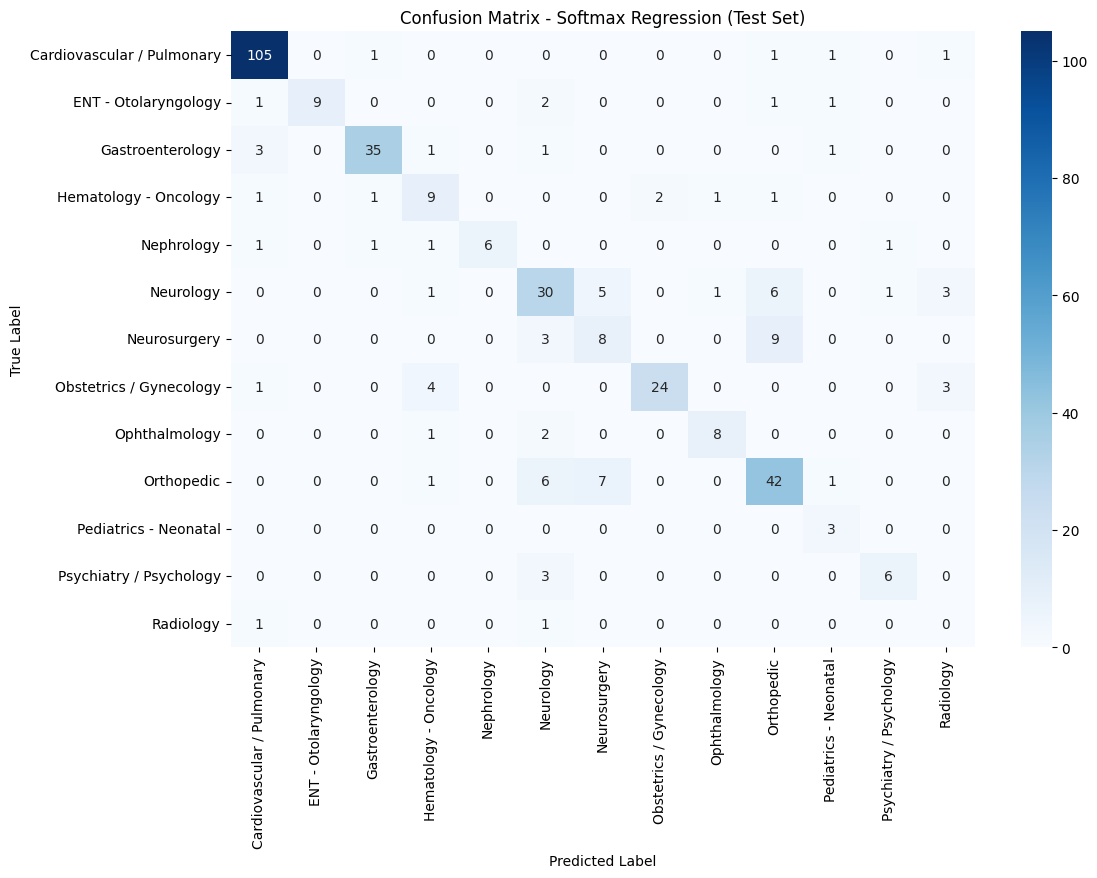

In [27]:
# Confusion Matrix

# Evaluate model on the test set
y_test_pred = best_softmax_model.predict(X_test)

# Generate confusion matrix on the test set
cm = confusion_matrix(y_test, y_test_pred, labels=class_names)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix - Softmax Regression (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
